In [1]:
import numpy as np
import os
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rc('text', usetex=True)
plt.rc('font', size=MEDIUM_SIZE) # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE, linewidth=2) # fontsize of the axes title
plt.rc('xtick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath \usepackage{bm} \usepackage{amsmath}'

In [2]:
E_IG = '/media/deepan/externaldrive1/project_repos/DEXT_versions/other_reports/EFFICIENTDETD0_IntegratedGradients'
E_GBP = '/media/deepan/externaldrive1/project_repos/DEXT_versions/other_reports/EFFICIENTDETD0_GuidedBackpropagation'

F_IG = '/media/deepan/externaldrive1/project_repos/DEXT_versions/other_reports/FasterRCNN_IntegratedGradients'
F_GBP = '/media/deepan/externaldrive1/project_repos/DEXT_versions/other_reports/FasterRCNN_GuidedBackpropagation'

S_IG = '/media/deepan/externaldrive1/project_repos/DEXT_versions/other_reports/SSD512_IntegratedGradients'
S_GBP = '/media/deepan/externaldrive1/project_repos/DEXT_versions/other_reports/SSD512_GuidedBackpropagation'

metric_files = ['class_flip', 'max_prob', 'reg_error']

saliency_image_paths = 'saliency_image_paths'
ap_curve_linspace = 100

result_combinations = [E_IG, E_GBP, F_IG, F_GBP, S_IG, S_GBP]

In [3]:
def get_history_file(result_dir, filename):
    if os.path.exists(result_dir):
        file = os.path.join(result_dir, filename)
        if os.path.exists(file):
            return file
        else:
            raise ValueError('File in directory unavailable') 
    else:
        raise ValueError('Result directory unavailable')

In [4]:
def get_image_index_counts(result_dir, filename):
    file = get_history_file(result_dir, filename)
    data = [json.loads(line) for line in open(file, 'r')]
    data = np.array(data)
    all_image_index = list(np.unique(data[:, 0]))
    return len(all_image_index)

In [5]:
model_saliency_paths = dict()
model_class_flips = dict()
model_max_prob = dict()
model_reg_error = dict()
for result_dir in result_combinations:
    model_name_interpretation = (result_dir.split('/')[-1])
    model_name = model_name_interpretation.split('_')[0]
    interpretation_method = model_name_interpretation.split('_')[1]
    print('Model name: %s | Interpretation method: %s' % (model_name, interpretation_method))
    print("Number of saliency image paths: ", get_image_index_counts(result_dir, saliency_image_paths))
    print("Number of evaluated images: ", get_image_index_counts(result_dir, metric_files[0]))
    model_class_flips[model_name_interpretation] = get_history_file(result_dir, metric_files[0])
    model_max_prob[model_name_interpretation] = get_history_file(result_dir, metric_files[1])
    model_reg_error[model_name_interpretation] = get_history_file(result_dir, metric_files[2])
print(model_class_flips)
print(model_max_prob)
print(model_reg_error)

Model name: EFFICIENTDETD0 | Interpretation method: IntegratedGradients
Number of saliency image paths:  50
Number of evaluated images:  50
Model name: EFFICIENTDETD0 | Interpretation method: GuidedBackpropagation
Number of saliency image paths:  50
Number of evaluated images:  50
Model name: FasterRCNN | Interpretation method: IntegratedGradients
Number of saliency image paths:  20
Number of evaluated images:  20
Model name: FasterRCNN | Interpretation method: GuidedBackpropagation
Number of saliency image paths:  30
Number of evaluated images:  30
Model name: SSD512 | Interpretation method: IntegratedGradients
Number of saliency image paths:  70
Number of evaluated images:  44
Model name: SSD512 | Interpretation method: GuidedBackpropagation
Number of saliency image paths:  89
Number of evaluated images:  87
{'EFFICIENTDETD0_IntegratedGradients': '/media/deepan/externaldrive1/project_repos/DEXT_versions/other_reports/EFFICIENTDETD0_IntegratedGradients/class_flip', 'EFFICIENTDETD0_Gui

/media/deepan/externaldrive1/project_repos/paz_versions/paz_efficientdet/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [6]:
def get_all_metric_df(metric_dict, metric_columns, linspaces, metric_name):
    all_metric_df = dict()
    for combination, filename in metric_dict.items():
        data = [json.loads(line) for line in open(filename, 'r')]
        df_metric_columns = metric_columns
        if linspaces:
            metric_percent_space = [metric_name + "_" + str(round(n, 2))
                            for n in np.linspace(0, 1, linspaces)]
            df_metric_columns = df_metric_columns + metric_percent_space
        df_metric = pd.DataFrame(data, columns=df_metric_columns)
        all_metric_df[combination] = df_metric
    return all_metric_df
        
# CLASS FLIP DFS
class_flip_columns = ["image_index", "object_index", "explaining", "boxoffset", "coordinates", "score",
                      "class", "iou", "centroid", "variance", "pixels_flipped"]
all_class_flip_df = get_all_metric_df(model_class_flips, class_flip_columns, None, 'class_flip')

# MAX PROB DFS
max_prob_columns = ["image_index", "object_index", "pixels_flipped", "explaining", "boxoffset",]
all_max_prob_df = get_all_metric_df(model_max_prob, max_prob_columns, ap_curve_linspace, 'max_prob')

# REG ERROR DFS
reg_error_columns = ["image_index", "object_index", "pixels_flipped", "explaining", "boxoffset",]
all_reg_error_df = get_all_metric_df(model_reg_error, reg_error_columns, ap_curve_linspace, 'reg_error')

In [7]:
display(all_max_prob_df['EFFICIENTDETD0_IntegratedGradients'])
display(all_reg_error_df['EFFICIENTDETD0_IntegratedGradients'])

,image_index,object_index,pixels_flipped,explaining,boxoffset,max_prob_0.0,max_prob_0.01,max_prob_0.02,max_prob_0.03,max_prob_0.04,...,max_prob_0.91,max_prob_0.92,max_prob_0.93,max_prob_0.94,max_prob_0.95,max_prob_0.96,max_prob_0.97,max_prob_0.98,max_prob_0.99,max_prob_1.0
0,122745,0,0.050505,Classification,None,0.946593,0.943833,0.925185,0.841232,0.693128,...,0,0,0,0,0,0,0,0,0,0
1,122745,0,0.050505,Boxoffset,1,0.946593,0.940417,0.906223,0.851430,0.727421,...,0,0,0,0,0,0,0,0,0,0
2,122745,0,0.050505,Boxoffset,0,0.946593,0.934744,0.924852,0.810202,0.721162,...,0,0,0,0,0,0,0,0,0,0
3,122745,0,0.050505,Boxoffset,3,0.946593,0.942988,0.938626,0.858567,0.522948,...,0,0,0,0,0,0,0,0,0,0
4,122745,0,0.050505,Boxoffset,2,0.946593,0.934076,0.914189,0.796334,0.651079,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,87038,4,0.020202,Boxoffset,1,0.655171,0.443334,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1112,87038,4,0.020202,Boxoffset,0,0.655171,0.607430,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1113,87038,4,0.020202,Boxoffset,3,0.655171,0.536995,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1114,87038,4,0.020202,Boxoffset,2,0.655171,0.517936,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


,image_index,object_index,pixels_flipped,explaining,boxoffset,reg_error_0.0,reg_error_0.01,reg_error_0.02,reg_error_0.03,reg_error_0.04,...,reg_error_0.91,reg_error_0.92,reg_error_0.93,reg_error_0.94,reg_error_0.95,reg_error_0.96,reg_error_0.97,reg_error_0.98,reg_error_0.99,reg_error_1.0
0,122745,0,0.050505,Classification,None,0.0,2.000000,2.414214,3.236068,4.236068,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,122745,0,0.050505,Boxoffset,1,0.0,2.414214,2.828427,5.236068,6.359174,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,122745,0,0.050505,Boxoffset,0,0.0,2.000000,3.000000,4.000000,4.236068,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
3,122745,0,0.050505,Boxoffset,3,0.0,2.000000,2.414214,3.000000,5.162278,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,122745,0,0.050505,Boxoffset,2,0.0,1.000000,2.000000,3.414214,4.236068,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,87038,4,0.020202,Boxoffset,1,0.0,5.019765,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1112,87038,4,0.020202,Boxoffset,0,0.0,4.000000,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1113,87038,4,0.020202,Boxoffset,3,0.0,6.513233,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1114,87038,4,0.020202,Boxoffset,2,0.0,4.000000,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [21]:
count_det = all_max_prob_df['EFFICIENTDETD0_IntegratedGradients'][all_max_prob_df['EFFICIENTDETD0_IntegratedGradients']['explaining'].isin(['combined'])]
display(count_det)

,image_index,object_index,pixels_flipped,explaining,boxoffset,max_prob_0.0,max_prob_0.01,max_prob_0.02,max_prob_0.03,max_prob_0.04,...,max_prob_0.91,max_prob_0.92,max_prob_0.93,max_prob_0.94,max_prob_0.95,max_prob_0.96,max_prob_0.97,max_prob_0.98,max_prob_0.99,max_prob_1.0
5,122745,0,0.040404,combined,combined,0.946593,0.937682,0.897167,0.718460,0.000000,...,0,0,0,0,0,0,0,0,0,0
11,143931,0,0.424242,combined,combined,0.869620,0.854392,0.853311,0.855255,0.857491,...,0,0,0,0,0,0,0,0,0,0
17,153299,0,0.474747,combined,combined,0.898515,0.857577,0.874050,0.885350,0.884977,...,0,0,0,0,0,0,0,0,0,0
23,153299,1,0.252525,combined,combined,0.757115,0.821421,0.851432,0.880619,0.875050,...,0,0,0,0,0,0,0,0,0,0
29,174482,0,0.666667,combined,combined,0.863497,0.865238,0.865865,0.861613,0.861830,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,87038,0,0.080808,combined,combined,0.763662,0.759558,0.742458,0.747110,0.757830,...,0,0,0,0,0,0,0,0,0,0
1097,87038,1,0.030303,combined,combined,0.628050,0.644953,0.455654,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1103,87038,2,0.010101,combined,combined,0.462904,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1109,87038,3,0.010101,combined,combined,0.446761,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [8]:
def plot_curve(mean_curve, range_values, key, ax):
    ax.plot(range_values, mean_curve, label=key)

In [9]:
def get_curve_labels(curve_type):
    xlabel, ylabel, title = '', '', ''
    if curve_type == 'AP_Curves':
        xlabel = r'\textbf{Fraction of pixels flipped}'
        ylabel = r'\textbf{AP$_{explain}$ @[IOU=0.50]}'
        title = r'\textbf{Net AP Curves}'
    elif curve_type == 'Max_Probability_Curves':
        xlabel = r'\textbf{Fraction of pixels flipped}'
#         ylabel = r'\textbf{Class$_{explain}$}'
        ylabel = r'\textbf{Class confidence average across all detections before pixel manipulation}'
        title = r'\textbf{Max Probability Curves}'
    elif curve_type == 'Regression_Error_Curves':
        xlabel = r'\textbf{Fraction of pixels flipped}'
#         ylabel = r'\textbf{Box$_{explain}$ (pixels)}'
        title = r'\textbf{Regression Error Curves}'
    return xlabel, ylabel, title

In [10]:
def calculate_mean_range(curve_df, regex):
    curve_df.loc["mean"] = curve_df.iloc[:, 5:].mean(axis=0)
    columns = curve_df.columns.to_numpy()
    percent50 = (curve_df.filter(regex=regex))
    mean_curve = percent50.iloc[-1, :].to_numpy()
    range_values = [float(val.split(regex)[1])
                    for val in percent50.columns]
    if 'max_prob' in regex:
        auc = np.trapz(mean_curve)
    else:
        auc = None
    return mean_curve, range_values, auc

In [11]:
def clean_sheet(df, regex):
    if regex == 'max_prob_':
        df_new = df[(df['explaining'] == 'Classification') & (df['boxoffset'].isnull())]
    elif regex == 'reg_error_':
        df_new = df[(df['explaining'] == 'Boxoffset') & (df['boxoffset'].isin([0, 1, 2, 3]))]
        df_new = df_new.replace([np.inf], 100)
    return df_new

In [12]:
def get_merged_sheet(df):
    df_new = df[(df['explaining'] == 'combined')]
    df_new = df_new.replace([np.inf], 100)
    return df_new

In [13]:
def compute_and_plot(files, regex, curve_type, savename, plot_merged=False):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    plt.subplots_adjust(left=0.099, right=0.95, top=0.9, bottom=0.15)
    
    for key, val in files.items():
        filtered_df = clean_sheet(val, regex)
        mean_curve, range_values, auc = calculate_mean_range(filtered_df, regex)
        key = key + (r'\textbf{ (AUC: }' +  r'\textbf{%s)}' % str(round(auc, 2))) if auc else key
        plot_curve(mean_curve, range_values, key, ax)   
        
    if plot_merged:
        for key, val in files.items():
            filtered_df = get_merged_sheet(val)
            mean_curve, range_values, auc = calculate_mean_range(filtered_df, regex)
            key = key + (r'\textbf{ (AUC: }' +  r'\textbf{%s), merged}' % str(round(auc, 2))) if auc else key + (r'\textbf{, merged}')
            plot_curve(mean_curve, range_values, key, ax)       
    
    xlabel, ylabel, title = get_curve_labels(curve_type)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if curve_type == 'Regression_Error_Curves':
        y_labels = (r'\textbf{0}', r'\textbf{20}', r'\textbf{40}', 
                    r'\textbf{60}', r'\textbf{$\vdots$}' ,r'\textbf{$\infty$}')
        y_ticks = [0, 20, 40, 60, 80, 100]
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_labels)
    ax.set_title(title)
    ax.legend()
    ax.grid()
    plt.savefig(savename + '.pdf', dpi=600)
    plt.show()

/media/deepan/externaldrive1/project_repos/paz_versions/paz_efficientdet/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/media/deepan/externaldrive1/project_repos/paz_versions/paz_efficientdet/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/media/deepan/externaldrive1/project_repos/paz_versions/paz_efficientdet/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying 

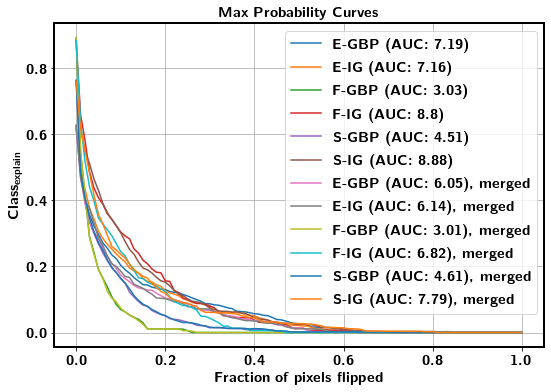

'Class$_{explain}$ is the average of the detection confidence across all\ndetections in the dataset when a fraction of most relevant pixels are flipped \nfor each detection in the image according to the explanation produced for the detection.\nThe confidence is tracked only for the detection explained at an instance.'

In [14]:
max_prob_sheets = {
    r'\textbf{E-GBP}': all_max_prob_df['EFFICIENTDETD0_GuidedBackpropagation'],
    r'\textbf{E-IG}': all_max_prob_df['EFFICIENTDETD0_IntegratedGradients'],
    r'\textbf{F-GBP}': all_max_prob_df['FasterRCNN_GuidedBackpropagation'],
    r'\textbf{F-IG}': all_max_prob_df['FasterRCNN_IntegratedGradients'],
    r'\textbf{S-GBP}': all_max_prob_df['SSD512_GuidedBackpropagation'],
    r'\textbf{S-IG}': all_max_prob_df['SSD512_IntegratedGradients'],
}
compute_and_plot(max_prob_sheets, regex='max_prob_', curve_type='Max_Probability_Curves', 
                 savename='max_prob_all', plot_merged=True)
'''Class$_{explain}$ is the average of the detection confidence across all
detections in the dataset when a fraction of most relevant pixels are flipped 
for each detection in the image according to the explanation produced for the detection.
The confidence is tracked only for the detection explained at an instance.'''

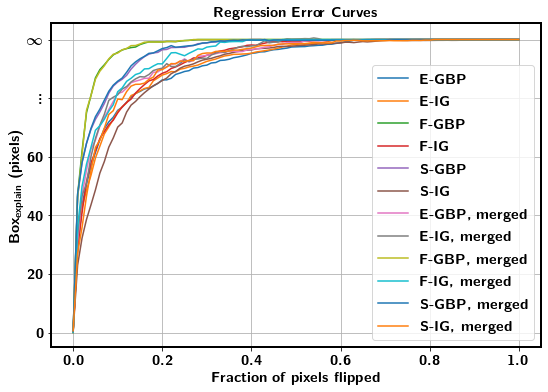

'Box$_{explain}$ is the average of the detection regression error across all\ndetections in the dataset when a fraction of most relevant pixels are flipped \nfor each detection in the image according to the explanation produced for the detection.\nThe regression error is calculated only for the detection under explanation with respect\nto the original image detections before flipping most relevant pixels.'

In [19]:
reg_error_sheets = {
    r'\textbf{E-GBP}': all_reg_error_df['EFFICIENTDETD0_GuidedBackpropagation'],
    r'\textbf{E-IG}': all_reg_error_df['EFFICIENTDETD0_IntegratedGradients'],
    r'\textbf{F-GBP}': all_reg_error_df['FasterRCNN_GuidedBackpropagation'],
    r'\textbf{F-IG}': all_reg_error_df['FasterRCNN_IntegratedGradients'],
    r'\textbf{S-GBP}': all_reg_error_df['SSD512_GuidedBackpropagation'],
    r'\textbf{S-IG}': all_reg_error_df['SSD512_IntegratedGradients'],
}
compute_and_plot(reg_error_sheets, regex='reg_error_', curve_type='Regression_Error_Curves',
                 savename='reg_error_all', plot_merged=True)
'''Box$_{explain}$ is the average of the detection regression error across all
detections in the dataset when a fraction of most relevant pixels are flipped 
for each detection in the image according to the explanation produced for the detection.
The regression error is calculated only for the detection under explanation with respect
to the original image detections before flipping most relevant pixels.'''

/media/deepan/externaldrive1/project_repos/paz_versions/paz_efficientdet/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/media/deepan/externaldrive1/project_repos/paz_versions/paz_efficientdet/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/media/deepan/externaldrive1/project_repos/paz_versions/paz_efficientdet/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying 

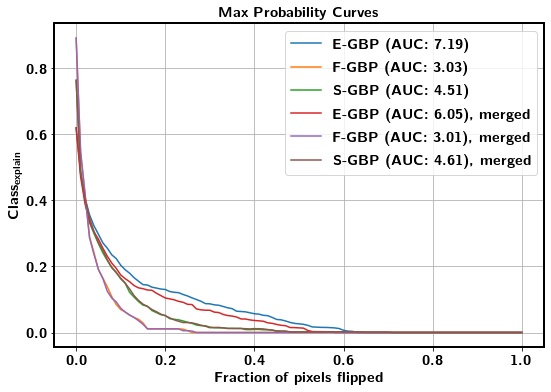

In [20]:
max_prob_sheets = {
    r'\textbf{E-GBP}': all_max_prob_df['EFFICIENTDETD0_GuidedBackpropagation'],
    r'\textbf{F-GBP}': all_max_prob_df['FasterRCNN_GuidedBackpropagation'],
    r'\textbf{S-GBP}': all_max_prob_df['SSD512_GuidedBackpropagation'],
}
compute_and_plot(max_prob_sheets, regex='max_prob_', curve_type='Max_Probability_Curves', 
                 savename='max_prob_gbp', plot_merged=True)

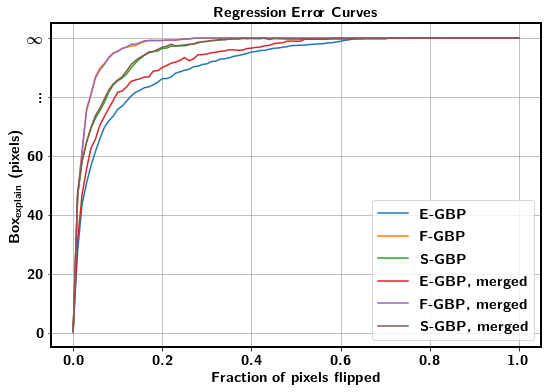

In [21]:
reg_error_sheets = {
    r'\textbf{E-GBP}': all_reg_error_df['EFFICIENTDETD0_GuidedBackpropagation'],
    r'\textbf{F-GBP}': all_reg_error_df['FasterRCNN_GuidedBackpropagation'],
    r'\textbf{S-GBP}': all_reg_error_df['SSD512_GuidedBackpropagation'],
}
compute_and_plot(reg_error_sheets, regex='reg_error_', curve_type='Regression_Error_Curves',
                 savename='reg_error_all', plot_merged=True)